# MODIS_L1B数据的NDVI计算

In [13]:
import gdal
import glob
import numpy as np
import matplotlib.pyplot as plt
from pyhdf import SD
from mpl_toolkits.basemap import Basemap
from mpl_toolkits.basemap import cm

In [14]:
# 数据所在目录
hdf_L1B=glob.glob('C:\\Users\Lenovo\Documents\MOD021KM.A2019123.0325*.hdf')# MODIS_L1B发射和反射率数据
print("MODIS L1B file found {}".format(hdf_L1B))
hdf_GEO=glob.glob('C:\\Users\Lenovo\Documents\MOD03.A2019123.0325*.hdf')# 地理校正数据
print("MODIS Geolocation file found {}".format(hdf_GEO))

MODIS L1B file found ['C:\\Users\\Lenovo\\Documents\\MOD021KM.A2019123.0325.061.2019123131709.hdf']
MODIS Geolocation file found ['C:\\Users\\Lenovo\\Documents\\MOD03.A2019123.0325.061.2019123083843.hdf']


In [15]:
L1B_obj=SD.SD(hdf_L1B[0], SD.SDC.READ)
GEO_obj=SD.SD(hdf_GEO[0], SD.SDC.READ)
print(L1B_obj.datasets().keys())

dict_keys(['Latitude', 'Longitude', 'EV_1KM_RefSB', 'EV_1KM_RefSB_Uncert_Indexes', 'EV_1KM_Emissive', 'EV_1KM_Emissive_Uncert_Indexes', 'EV_250_Aggr1km_RefSB', 'EV_250_Aggr1km_RefSB_Uncert_Indexes', 'EV_250_Aggr1km_RefSB_Samples_Used', 'EV_500_Aggr1km_RefSB', 'EV_500_Aggr1km_RefSB_Uncert_Indexes', 'EV_500_Aggr1km_RefSB_Samples_Used', 'Height', 'SensorZenith', 'SensorAzimuth', 'Range', 'SolarZenith', 'SolarAzimuth', 'gflags', 'EV_Band26', 'EV_Band26_Uncert_Indexes', 'Band_250M', 'Band_500M', 'Band_1KM_RefSB', 'Band_1KM_Emissive', 'Noise in Thermal Detectors', 'Change in relative responses of thermal detectors', 'DC Restore Change for Thermal Bands', 'DC Restore Change for Reflective 250m Bands', 'DC Restore Change for Reflective 500m Bands', 'DC Restore Change for Reflective 1km Bands'])


In [16]:
# 找到对应的红色和热红外波段所在数据集，为了后面的云掩模准备
raw_red=L1B_obj.select('EV_250_Aggr1km_RefSB')[:]# 红色波段所在
raw_nir=L1B_obj.select('EV_250_Aggr1km_RefSB')[:]# 近红外波段所在

In [17]:
# 检查数据集属性
print("Size of 'EV_250_Aggr1km_RefSB': {}".format(raw_red.shape))
print("Size of 'EV_250_Aggr1km_RefSB': {}".format(raw_nir.shape))
print("Attributies of 'EV_250_Aggr1km_RefSB'\n===============================")
print(L1B_obj.select('EV_250_Aggr1km_RefSB').attributes())

Size of 'EV_250_Aggr1km_RefSB': (2, 2030, 1354)
Size of 'EV_250_Aggr1km_RefSB': (2, 2030, 1354)
Attributies of 'EV_250_Aggr1km_RefSB'
{'long_name': 'Earth View 250M Aggregated 1km Reflective Solar Bands Scaled Integers', 'units': 'none', 'valid_range': [0, 32767], '_FillValue': 65535, 'band_names': '1,2', 'radiance_scales': [0.029133934527635574, 0.010844415053725243], 'radiance_offsets': [-0.0, -0.0], 'radiance_units': 'Watts/m^2/micrometer/steradian', 'reflectance_scales': [5.789205897599459e-05, 3.488319998723455e-05], 'reflectance_offsets': [-0.0, -0.0], 'reflectance_units': 'none', 'corrected_counts_scales': [0.12497329711914062, 0.12497329711914062], 'corrected_counts_offsets': [-0.0, -0.0], 'corrected_counts_units': 'counts'}


In [18]:
# 选择参数
band_names=L1B_obj.select('EV_250_Aggr1km_RefSB').attributes()['band_names']# 选择波段
reflectance_scales=L1B_obj.select('EV_250_Aggr1km_RefSB').attributes()['reflectance_scales']# 选择辐射定标所需的参数值
reflectance_offsets=L1B_obj.select('EV_250_Aggr1km_RefSB').attributes()['reflectance_offsets']# 选择辐射定标所需的参数值

In [19]:
# 构建参数的矩阵
band_names=np.fromstring(band_names, dtype=np.float, sep=',')
print(band_names)
reflectance_scales=np.array(reflectance_scales)
print(reflectance_scales)
reflectance_offsets=np.array(reflectance_offsets)
print(reflectance_scales)

[1. 2.]
[5.7892059e-05 3.4883200e-05]
[5.7892059e-05 3.4883200e-05]


In [20]:
# 红色波段辐射定标
hit=band_names==1
raw_red=raw_red[hit, :, :]
Band_red=(raw_red - reflectance_offsets[hit] * np.ones(raw_red.shape)) * reflectance_scales[hit]

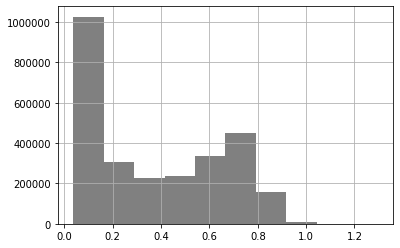

In [21]:
# 绘制红色波段直方图，横坐标值应该在0-1左右
plt.hist(Band_red.flat, color='gray')
plt.grid()

In [22]:
# 近红外波段辐射定标
hit1=band_names==2
raw_nir=raw_nir[hit1, :, :]
Band_nir=(raw_nir - reflectance_offsets[hit1] * np.ones(raw_red.shape)) * reflectance_scales[hit1]

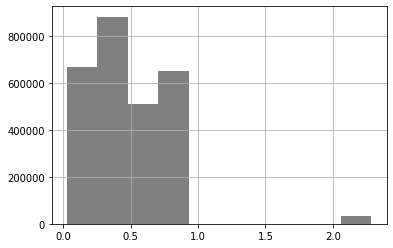

In [23]:
# 绘制红色波段直方图，横坐标值应该在0-1之间
plt.hist(Band_nir.flat, color='gray')
plt.grid()

In [24]:
# 计算NDVI,NDVI=(近红外-红色)/(近红外+红色)
NDVI = 1.0*(Band_nir - Band_red) / (Band_nir + Band_red)

In [25]:
print(GEO_obj.datasets().keys())# 查看地理校正文件属性

dict_keys(['Latitude', 'Longitude', 'Scan Offset', 'Track Offset', 'Height Offset', 'Height', 'SensorZenith', 'SensorAzimuth', 'Range', 'SolarZenith', 'SolarAzimuth', 'Land/SeaMask', 'WaterPresent', 'gflags', 'Scan number', 'EV frames', 'SD frames', 'SV frames', 'EV start time', 'SD start time', 'SV start time', 'EV center time', 'Mirror side', 'SD Sun zenith', 'SD Sun azimuth', 'Moon Vector', 'L1 scan quality', 'Geo scan quality', 'orb_pos', 'orb_vel', 'T_inst2ECR', 'attitude_angles', 'sun_ref', 'num_impulse', 'impulse_enc', 'impulse_time', 'Scan Type', 'thermal_correction', 'attitude_quality', 'ephemeris_quality', 'Focal_length', 'band_position', 'detector_space', 'detector_offsets', 'T_offset', 'num_samples'])


In [26]:
C_x=GEO_obj.select('Longitude')[:]
C_y=GEO_obj.select('Latitude')[:]

In [27]:
# 检查数据大小
print("Size of 'Longitude': {}".format(C_x.shape))
print("Size of 'Latitude': {}".format(C_y.shape))

Size of 'Longitude': (2030, 1354)
Size of 'Latitude': (2030, 1354)


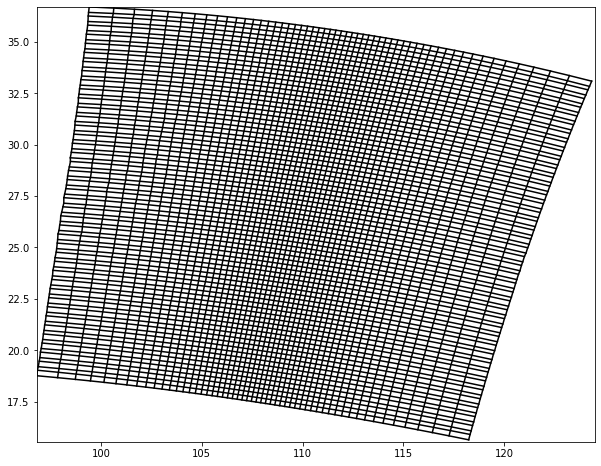

In [28]:
# 绘制经纬网
fig=plt.figure(figsize=(10, 8))
axis=plt.gca()
axis.set_xlim(C_x.min(), C_x.max())
axis.set_ylim(C_y.min(), C_y.max())
axis.plot(C_x[::25, ::25], C_y[::25, ::25], 'k-');
axis.plot(C_x[::25, ::25].T, C_y[::25, ::25].T, 'k-');

In [29]:
# 定义新的投影模型
def reproj_L1B(raw_data, raw_x, raw_y, xlim, ylim, res):
    
    '''
    =======================================================================
    Reproject MODIS L1B file to a regular grid
                            ----- created on 2014/12/18
    -----------------------------------------------------------------------
    d_array, x_array, y_array, bin_count = reproj_L1B(...)
    -----------------------------------------------------------------------
    Input:
            raw_data: L1B data, N*M 2-D array.
            raw_x: longitude info. N*M 2-D array.
            raw_y: latitude info. N*M 2-D array.
            xlim: range of longitude, a list.
            ylim: range of latitude, a list.
            res: resolution, res=[res_lon, res_lat].
    Output:
            d_array: L1B reprojected data.
            x_array: reprojected longitude.
            y_array: reprojected latitude.
            bin_count: how many raw data point included in a reprojected grid.
    Note:
            function do not performs well if "res" is higher than the resolution of input data. 
            Size of "raw_data", "raw_x", "raw_y" must agree.
    =======================================================================
    '''
    import numpy as np
    
    x_bins=np.arange(xlim[0], xlim[1], res[0])
    y_bins=np.arange(ylim[0], ylim[1], res[1])
#    x_indices=np.digitize(raw_x.flat, x_bins)
#    y_indices=np.digitize(raw_y.flat, y_bins)
    x_indices=np.searchsorted(x_bins, raw_x.flat, 'right')
    y_indices=np.searchsorted(y_bins, raw_y.flat, 'right')
        
    y_array=np.zeros([len(y_bins), len(x_bins)], dtype=np.float)
    x_array=np.zeros([len(y_bins), len(x_bins)], dtype=np.float)
    d_array=np.zeros([len(y_bins), len(x_bins)], dtype=np.float)
    bin_count=np.zeros([len(y_bins), len(x_bins)], dtype=np.int)
    
    for n in range(len(y_indices)): 
        bin_row=y_indices[n]-1 
        bin_col=x_indices[n]-1
        bin_count[bin_row, bin_col] += 1
        x_array[bin_row, bin_col] += raw_x.flat[n]
        y_array[bin_row, bin_col] += raw_y.flat[n]
        d_array[bin_row, bin_col] += raw_data.flat[n]
                   
    for i in range(x_array.shape[0]):
        for j in range(x_array.shape[1]):
            if bin_count[i, j] > 0:
                x_array[i, j]=x_array[i, j]/bin_count[i, j]
                y_array[i, j]=y_array[i, j]/bin_count[i, j]
                d_array[i, j]=d_array[i, j]/bin_count[i, j] 
            else:
                d_array[i, j]=np.nan
                x_array[i, j]=np.nan
                y_array[i,j]=np.nan
                
    return d_array, x_array, y_array, bin_count

In [30]:
# 对NDVI进行地理校正
xlim=[np.min(C_x), np.max(C_x)]
ylim=[np.min(C_y), np.max(C_y)]
NDVI_grid, longitude, latitude, bin_count = reproj_L1B(NDVI, C_x, C_y, xlim, ylim, res=[0.05, 0.05])

D:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: MatplotlibDeprecationWarning: 
The dedent function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use inspect.cleandoc instead.
  after removing the cwd from sys.path.


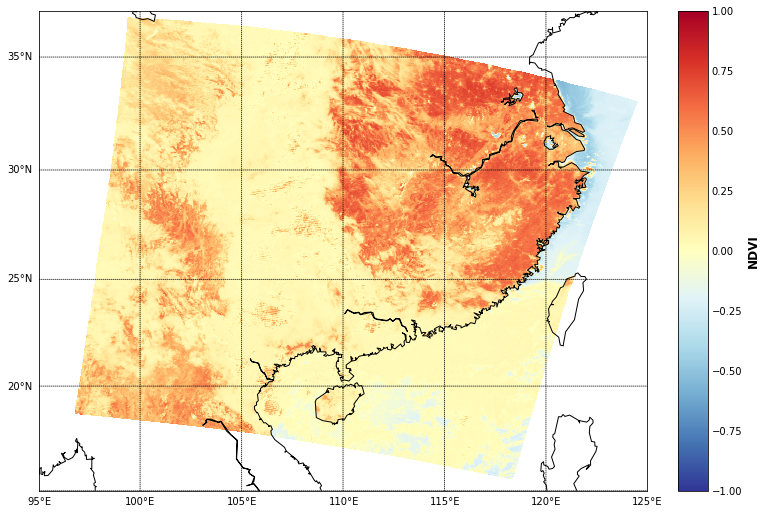

In [40]:
# 绘制经地理校正的NDVI数据
CMap=plt.cm.RdYlBu_r
proj=Basemap(resolution='l', projection='mill',\
             lat_1=30, lat_2=60, lat_0=45, lon_0=-140,llcrnrlon=95, llcrnrlat=15, urcrnrlon=125, urcrnrlat=37)
fig=plt.figure(figsize=(12, 12))
ax=plt.gca()
parallels=np.arange(-90, 90, 5)
meridians=np.arange(0, 360, 5)
proj.drawparallels(parallels, labels=[1, 0, 0, 0], fontsize=10, latmax=90)
proj.drawmeridians(meridians, labels=[0, 0, 0, 1], fontsize=10, latmax=90)
proj.drawcoastlines(linewidth=1.0, linestyle='solid', color='k')
x, y=proj(longitude, latitude)
CS=proj.pcolor(x, y, NDVI_grid, cmap=CMap, vmin=-1, vmax=1)
CBar=proj.colorbar(CS, 'right', size='5%', pad='5%')
CBar.set_label('NDVI', fontsize=12, fontweight='bold')
CBar.ax.tick_params(axis='y', length=0)

In [41]:
raw_C31=L1B_obj.select('EV_1KM_Emissive')[:]# 第31波段所在目录，31波段为热红外波

In [42]:
# 选择参数
band_names2=L1B_obj.select('EV_1KM_Emissive').attributes()['band_names']
print(band_names2)
radiance_scales2=L1B_obj.select('EV_1KM_Emissive').attributes()['radiance_scales']
print(radiance_scales2)
radiance_offsets2=L1B_obj.select('EV_1KM_Emissive').attributes()['radiance_offsets']
print(radiance_offsets2)

20,21,22,23,24,25,27,28,29,30,31,32,33,34,35,36
[6.262398528633639e-05, 0.0031495101284235716, 6.921597378095612e-05, 7.910397835075855e-05, 3.155614103889093e-05, 5.639820665237494e-05, 0.00011755729792639613, 0.0001924497337313369, 0.000532486941665411, 0.0004063234373461455, 0.0008400219958275557, 0.000729697581846267, 0.00026226387126371264, 0.00020069582387804985, 0.0001767082721926272, 0.0001183385684271343]
[2730.58349609375, 2730.58349609375, 2730.58349609375, 2730.58349609375, 1077.44482421875, 1560.3333740234375, 2730.583251953125, 2317.48828125, 2730.58349609375, 1560.333251953125, 1577.3397216796875, 1658.2213134765625, 2501.297607421875, 2501.297607421875, 2501.2978515625, 2501.2978515625]


In [43]:
# 构造矩阵
band_names2=np.fromstring(band_names2, dtype=np.float, sep=',')
print(band_names2)
radiance_scales2=np.array(radiance_scales2)
print(radiance_scales2)
radiance_offsets2=np.array(radiance_offsets2)
print(radiance_offsets2)

[20. 21. 22. 23. 24. 25. 27. 28. 29. 30. 31. 32. 33. 34. 35. 36.]
[6.26239853e-05 3.14951013e-03 6.92159738e-05 7.91039784e-05
 3.15561410e-05 5.63982067e-05 1.17557298e-04 1.92449734e-04
 5.32486942e-04 4.06323437e-04 8.40021996e-04 7.29697582e-04
 2.62263871e-04 2.00695824e-04 1.76708272e-04 1.18338568e-04]
[2730.58349609 2730.58349609 2730.58349609 2730.58349609 1077.44482422
 1560.33337402 2730.58325195 2317.48828125 2730.58349609 1560.33325195
 1577.33972168 1658.22131348 2501.29760742 2501.29760742 2501.29785156
 2501.29785156]


In [44]:
# 第31波段辐射定标
hit2=band_names2==31
print(hit2)
raw_C31=raw_C31[hit2, :, :]
C31=(raw_C31 - radiance_offsets2[hit2] * np.ones(raw_C31.shape)) * radiance_scales2[hit2]

[False False False False False False False False False False  True False
 False False False False]


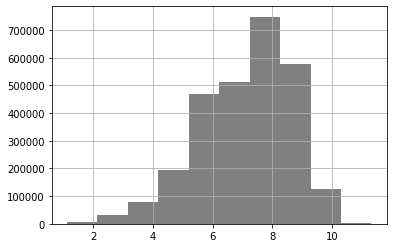

In [45]:
# 查看辐射定标结果
plt.hist(C31.flat, color='gray')
plt.grid()

In [46]:
# 对辐射定标后的第31波段和第1波段进行地理校正
C31_grid, longitude, latitude, bin_count = reproj_L1B(C31, C_x, C_y, xlim, ylim, res=[0.05, 0.05])
C1_grid, longitude, latitude, bin_count = reproj_L1B(Band_red, C_x, C_y, xlim, ylim, res=[0.05, 0.05])

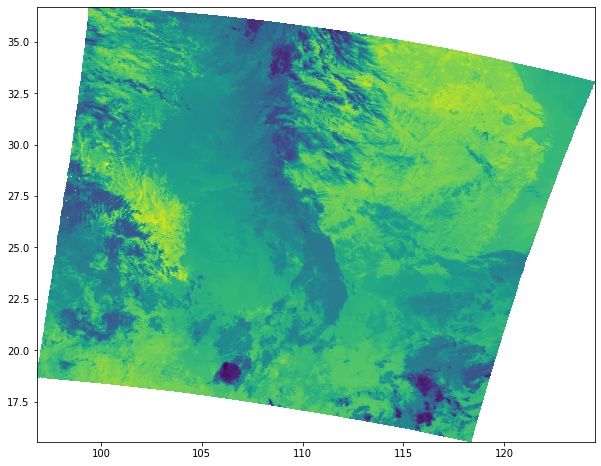

In [47]:
# 查看第31波段地理校正结果
fig=plt.figure(figsize=(10, 8))
ax=plt.gca()
ax.set_xlim(xlim[0], xlim[1])
ax.set_ylim(ylim[0], ylim[1])
image=ax.pcolor(longitude, latitude,C31_grid)

In [48]:
#云识别
C31_bins = 100
C31_lim=[np.nanmin(C31_grid), np.nanmax(C31_grid)]
C31_bins=np.linspace(C31_lim[0], C31_lim[1], C31_bins, dtype=np.float)
C1_bins = 150 
C1_lim=[np.nanmin(C1_grid), np.nanmax(C1_grid)]
C1_bins=np.linspace(C1_lim[0], C1_lim[1], C1_bins, dtype=np.float)
y=C31_grid.flat[:]; y_bins=C31_bins # x: C31
x=C1_grid.flat[:]; x_bins=C1_bins # y: C1
H, y_edges, x_edges = np.histogram2d(y, x, bins=(y_bins, x_bins))
X, Y = np.meshgrid(x_edges[:-1], y_edges[:-1])

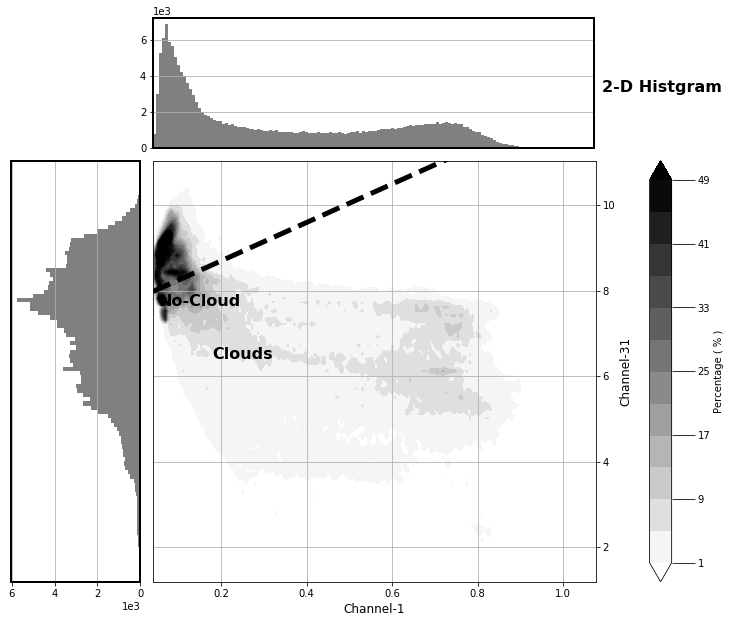

In [49]:
#2维散点图和设置分割线区分云
from mpl_toolkits.axes_grid1 import make_axes_locatable
# 设置横坐标
left=0.1; width = 0.8; bottom=0.1; height = 0.65
gap=0.02; hist_len=0.2; cbar_len=0.12
# 定义三个图
rect_main  = [left+hist_len+gap, bottom, width, height]
rect_histx = [left+hist_len+gap, left+height+gap, width-cbar_len, hist_len]
rect_histy = [left, bottom, hist_len, height]
clevs=np.arange(1, 50, 4)
CMap=plt.cm.gray_r
CMap.set_over(CMap(np.arange(256))[-1, 0:3])
CMap.set_under('w')
xlim_bin=[np.min(X), np.max(X)]
ylim_bin=[np.min(Y), np.max(Y)]
# ========== 图 ========== #
fig=plt.figure(figsize=(9, 9))
# ========== 主图 ========== #
axMain=plt.axes(rect_main)
axMain.yaxis.tick_right()
axMain.yaxis.set_label_position('right')
axMain.set_xlim(xlim_bin)
axMain.set_ylim(ylim_bin)
axMain.set_xlabel('Channel-1', fontsize=12)
axMain.set_ylabel('Channel-31', fontsize=12)
axMain.set_title('2-D Histgram', fontsize=16, fontweight='bold', x=1.15, y=1.15)
divider=make_axes_locatable(axMain)
plt.grid() 
#[i.set_linewidth(2) for i in axMain.spines.iter] 
CS=axMain.contourf(X, Y, H/np.max(H)*100, clevs, cmap=CMap, extend='both') # 2-D histgram
CAx=divider.append_axes('right', size='5%', pad=0.75)
CBar=plt.colorbar(CS, cax=CAx)
CBar.set_label('Percentage ( % )', fontsize=10)
CBar.ax.tick_params(axis='y', length=22.5)
# 绘制分割线
axMain.plot(x_edges, x_edges*4.5+7.8*np.ones(x_edges.shape),color='k', linestyle='--', linewidth=5)
axMain.text(0.25, 6.5, 'Clouds', fontsize=16, fontweight='bold',ha='center', va='center', color='k')
axMain.text(0.15, 7.75, 'No-Cloud', fontsize=16, fontweight='bold',ha='center', va='center', color='k')
# ========== 横坐标图 ========== #
axHistx=plt.axes(rect_histx)
axHistx.hist(x, bins=x_bins, color=[0.5, 0.5, 0.5])
axHistx.set_xlim(xlim_bin)
axHistx.axes.get_xaxis().set_visible(False)
# scientific notation for x, y-axis
plt.ticklabel_format(style='sci', axis='both', scilimits=(0,0))
[i.set_linewidth(2) for i in axHistx.spines.values()]
plt.grid()
# ========== 纵坐标图 ========== #
axHisty = plt.axes(rect_histy)
axHisty.hist(y, bins=y_bins, color=[0.5, 0.5, 0.5], orientation='horizontal')
axHisty.set_ylim(ylim_bin)
axHisty.invert_xaxis()
axHisty.axes.get_yaxis().set_visible(False)
plt.ticklabel_format(style='sci', axis='both', scilimits=(0,0))
[i.set_linewidth(2) for i in axHisty.spines.values()]
plt.grid()

Text(0.125, 7.75, 'No-Cloud')

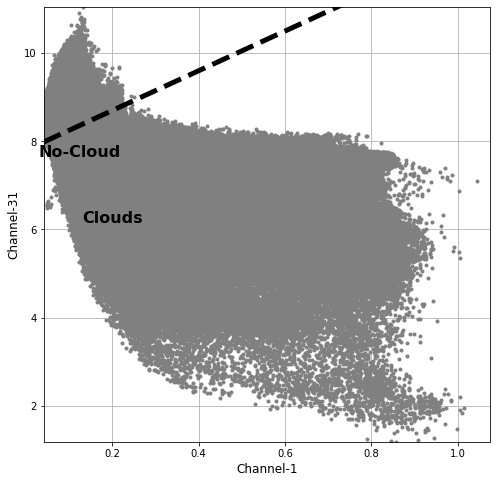

In [50]:
#绘制散点图
fig=plt.figure(figsize=(8, 8))
ax=plt.gca()
plt.grid()
ax.set_xlim(xlim_bin[0], xlim_bin[1])
ax.set_ylim(ylim_bin[0], ylim_bin[1])
ax.set_xlabel('Channel-1', fontsize=12)
ax.set_ylabel('Channel-31', fontsize=12)
ax.plot(x, y, color=[0.5, 0.5, 0.5], marker='.', linestyle='None')
ax.plot(x_edges, x_edges*4.5+7.8*np.ones(x_edges.shape), linestyle='--', color='k', linewidth=5)
ax.text(0.2, 6.25, 'Clouds', fontsize=16, fontweight='bold', ha='center', va='center', color='k')
ax.text(0.125, 7.75, 'No-Cloud', fontsize=16, fontweight='bold', ha='center', va='center', color='k')

In [51]:
# 应用分割线
criteria_k=5
cirteria_b=7.7
C1_clouds=np.empty((C31_grid.shape[0], C31_grid.shape[1],))
C1_clouds[:]=np.nan
C31_clouds=np.empty((C31_grid.shape[0], C31_grid.shape[1],))
C31_clouds[:]=np.nan
for i in range(C31_grid.shape[0]):
    for j in range(C31_grid.shape[1]):
        if(C31_grid[i, j] > C1_grid[i, j]*0.3+cirteria_b):
#            print(C31_grid[i, j])
            C31_clouds[i, j]=C31_grid[i, j]

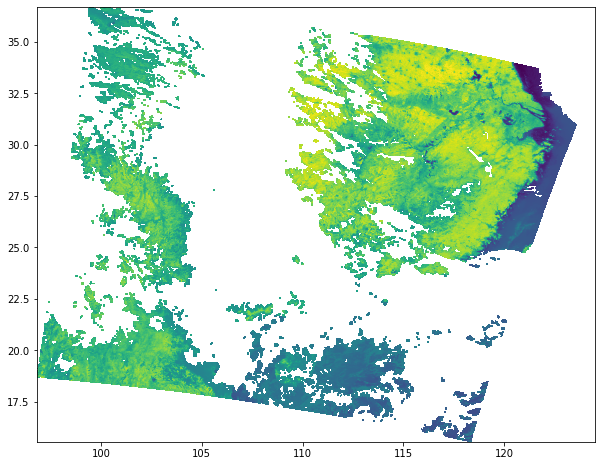

In [52]:
# 对NDVI掩膜
NDVI_clouds_masked=np.ma.masked_where(np.isnan(C31_clouds), NDVI_grid)
fig=plt.figure(figsize=(10, 8))
ax=plt.gca()
ax.set_xlim(xlim[0], xlim[1])
ax.set_ylim(ylim[0], ylim[1])
image=ax.pcolor(longitude, latitude, NDVI_clouds_masked)

D:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: MatplotlibDeprecationWarning: 
The dedent function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use inspect.cleandoc instead.
  after removing the cwd from sys.path.


Text(0.5, 1.0, 'MODIS_L1B_NDVI ')

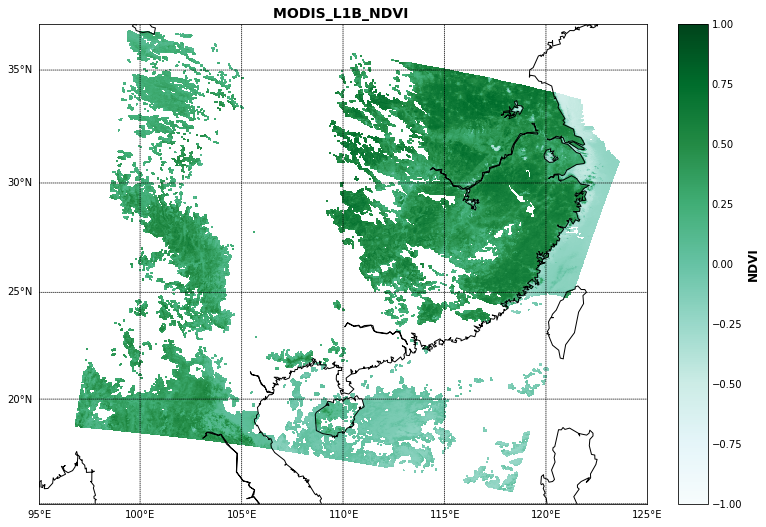

In [53]:
#绘制最终NDVI图
CMap=plt.cm.BuGn
proj=Basemap(resolution='l', projection='mill',\
             lat_1=10, lat_2=60, lat_0=32, lon_0=-140,llcrnrlon=95, llcrnrlat=15, urcrnrlon=125, urcrnrlat=37)
fig=plt.figure(figsize=(12, 12))
ax=plt.gca()
parallels=np.arange(-90, 90, 5)
meridians=np.arange(0, 360, 5)
proj.drawparallels(parallels, labels=[1, 0, 0, 0], fontsize=10, latmax=90)
proj.drawmeridians(meridians, labels=[0, 0, 0, 1], fontsize=10, latmax=90)
# 绘制海岸线
proj.drawcoastlines(linewidth=1.0, linestyle='solid', color='k')
# 格网
x, y=proj(longitude, latitude)
# 主图
CS=proj.pcolor(x, y, NDVI_clouds_masked, cmap=CMap, vmin=-1, vmax=1)
# 图例
CBar=proj.colorbar(CS, 'right', size='5%', pad='5%')
CBar.set_label('NDVI', fontsize=12, fontweight='bold')
CBar.ax.tick_params(axis='y', length=0)
# 标题
ax.set_title('MODIS_L1B_NDVI ',fontweight='bold',fontsize=14)

In [ ]:
# 保存图片
plt.savefig('MODIS_L1B_NDVI.png', dpi=250, facecolor='w', edgecolor='w',
            orientation='portrait', papertype='a4', format='png',
            transparent=True, bbox_inches='tight', pad_inches=0,
          frameon=None)